Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 2.8 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3156242 sha256=3ceec580b42388532373c4c526cab107ed30913c28ffa87f4d54dea718f6121e
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
# Import packages
import os
import pandas as pd
import numpy as np
import itertools
import collections
import networkx as nx
import six
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext

from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split

import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Change to your own directory
try: 
    os.chdir("/content/drive/MyDrive/Suicide")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [ ]:
# Set constants
SEED = 4222

Original Dataset

In [ ]:
# Load dataset
df = pd.read_csv('New Data/Suicide_dataset.csv')
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,I recently went through a breakup and she said...,depression
1,"I do not know how to navigate these feelings, ...",depression
2,"So I have been with my bf for 5 months , and h...",depression
3,I am so exhausted of this. Just when I think I...,suicide
4,i could feel the strongest connection and stil...,normal


In [ ]:
df.keys()

Index(['                                                                           text', '    class'], dtype='object')

In [ ]:
# Check for null values
df.isnull().sum()

                                                                           text    0
    class                                                                          1
dtype: int64

#ERROR!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

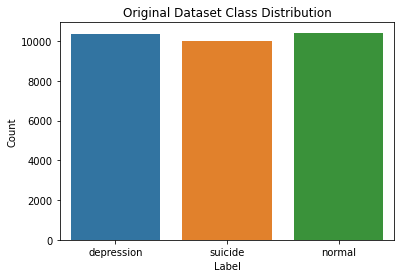

In [ ]:
# Check class distribution
print(df['                                                                           text'].value_counts())
print(df['    class'].value_counts(normalize=True))

sns.countplot(x=df['    class'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [ ]:
# Check lowercase
lowercase = df['                                                                           text'].str.islower()
print(lowercase.value_counts())

# df['text'][lowercase == True]

False    19927
True     10862
Name:                                                                            text, dtype: int64


In [ ]:
# Check extra whitespace
extra_whitespace = df['                                                                           text'].str.match('\s\s+')
print(extra_whitespace.value_counts())

# df['text'][extra_whitespace == True]


False    30789
Name:                                                                            text, dtype: int64


In [ ]:
# Check URL
url = df['                                                                           text'].str.contains("http")
print(url.value_counts())

# df['text'][url == True]

False    30665
True       124
Name:                                                                            text, dtype: int64


In [ ]:
# Check mentions
mention = df['                                                                           text'].str.match('@(\w+)')
print(mention.value_counts())

# df['text'][mention == True]


False    30789
Name:                                                                            text, dtype: int64


In [ ]:
# Check hashtags
hashtag = df['                                                                           text'].str.match('#(\w+)')
print(hashtag.value_counts())

# df['text'][hashtag == True]

False    30780
True         9
Name:                                                                            text, dtype: int64


In [ ]:
# Check subreddit tag
subreddit = df['                                                                           text'].str.match('r/(\w+)')
print(subreddit.value_counts())

# df['text'][subreddit == True]

False    30789
Name:                                                                            text, dtype: int64


In [ ]:
# Check users tag
users = df['                                                                           text'].str.match('u/(\w+)')
print(users.value_counts())

# df['text'][users == True]

False    30789
Name:                                                                            text, dtype: int64


In [ ]:
# Check special characters
special_characters = df['                                                                           text'].str.match('[^0-9a-zA-Z]+')
print(special_characters.value_counts())

# df['text'][special_characters == True]


False    30541
True       248
Name:                                                                            text, dtype: int64



Cleaned Dataset

In [ ]:
# Load dataset
clean_df = pd.read_csv('New Data/suicide_final_cleaned.csv', header=0)
clean_df.dropna(inplace = True)
clean_df

,text,class,cleaned_text
0,I recently went through a breakup and she said...,depression,recently go breakup say want friend say try ta...
1,"I do not know how to navigate these feelings, ...",depression,not know navigate feeling not new feeling stre...
2,"So I have been with my bf for 5 months , and h...",depression,month tell depressed week particular happen fe...
3,I am so exhausted of this. Just when I think I...,suicide,exhausted think finally rest think maybe thing...
4,i could feel the strongest connection and stil...,normal,feel strong connection divine self
...,...,...,...
30784,i get the more confident i feel about being we...,normal,confident feel prepared graduate
30785,i sat there in our living room feeling the sun...,normal,sit living room feel sun come window cuddle go...
30786,i still feel incredibly listless being in albu...,normal,feel incredibly listless albuquerque weather i...
30787,i feel that is how we can be safe to be oursel...,normal,feel safe trust


In [ ]:
# Check for null values
clean_df.isnull().sum()

                                                                           text    0
    class                                                                          0
cleaned_text                                                                       0
dtype: int64

In [ ]:
# Split dataset into train and test sets 
train_data, test_data = train_test_split(clean_df,
                                         test_size=0.2, 
                                         random_state=SEED,
                                         stratify=clean_df['    class'])

In [ ]:
# Split train set into classes
train_data_suicidal = train_data[train_data['    class'] == "suicide"]
train_data_depression = train_data[train_data['    class'] == "depression"]
train_data_normal = train_data[train_data['    class'] == "normal"]

Full dataset

normal        10428
depression    10369
suicide        9987
Name:     class, dtype: int64
normal        0.338747
depression    0.336831
suicide       0.324422
Name:     class, dtype: float64


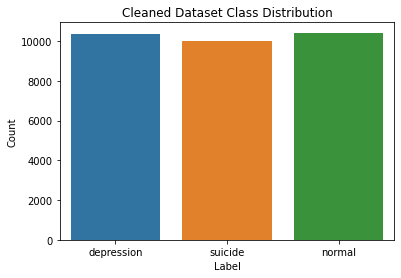

In [ ]:
# Check class distribution
print(clean_df['    class'].value_counts())
print(clean_df['    class'].value_counts(normalize=True))

sns.countplot(x=clean_df['    class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Train dataset

normal        8342
depression    8295
suicide       7990
Name:     class, dtype: int64
normal        0.338734
depression    0.336825
suicide       0.324441
Name:     class, dtype: float64


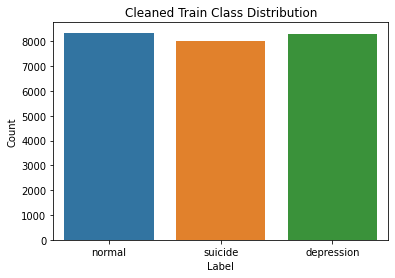

In [ ]:
# Check class distribution
print(train_data['    class'].value_counts())
print(train_data['    class'].value_counts(normalize=True))

sns.countplot(x=train_data['    class'])
plt.title('Cleaned Train Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Suicidal Text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_suicidal['cleaned_text'])

In [ ]:
tokenizer.word_counts.items()

odict_items([('nylon', 4), ('sleep', 907), ('tablet', 16), ('marital', 1), ('oprah', 5), ('codeine', 7), ('paracetamol', 31), ('overdose', 207), ('kill', 2863), ('petite', 3), ('skinny', 29), ('small', 231), ('leave', 1775), ('not', 28920), ('right', 1483), ('switch', 53), ('life', 6471), ('die', 3386), ('want', 9942), ('body', 520), ('scary', 82), ('tactic', 8), ('end', 2760), ('work', 2231), ('igottahangmyself', 2), ('entity', 9), ('power', 87), ('go', 4835), ('jail', 32), ('eventually', 227), ('outside', 194), ('constantly', 398), ('think', 4880), ('know', 6616), ('people', 3896), ('d', 425), ('dead', 631), ('come', 1513), ('funeral', 54), ('cry', 704), ('claim', 47), ('friend', 3136), ('care', 1956), ('death', 853), ('insignificant', 14), ('list', 95), ('close', 722), ('rank', 5), ('base', 54), ('watch', 366), ('happen', 1143), ('cut', 590), ('hurt', 1329), ('drug', 274), ('question', 248), ('good', 2574), ('case', 163), ('scenario', 37), ('thousand', 26), ('debt', 117), ('broken',

In [ ]:
word_freq_suicidal = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

Word Frequency Bar Graph

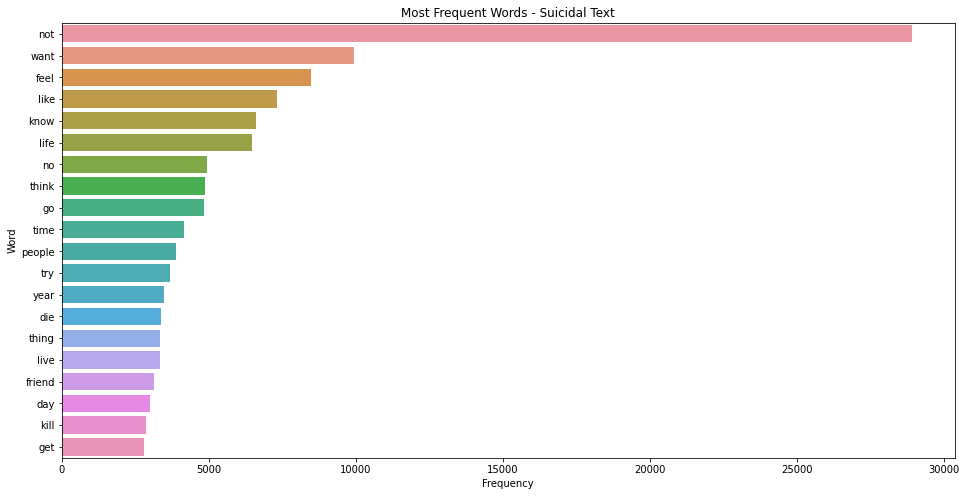

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

Wordcloud

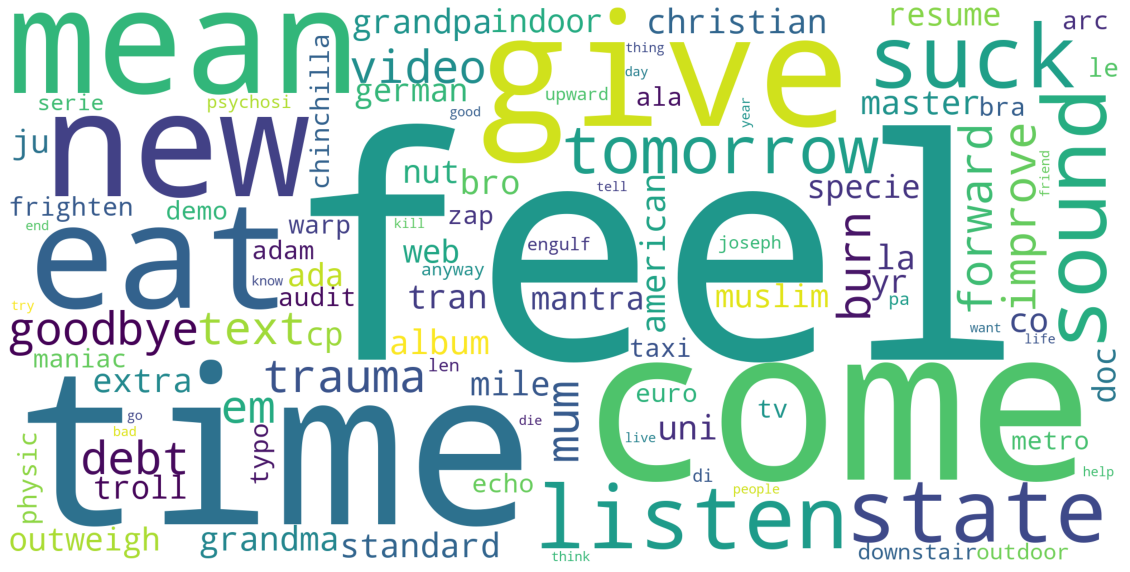

In [ ]:
# Wordcloud 
feature_names=word_freq_suicidal['word'].values
wc=WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

Distribution of Text Length

In [ ]:
# Get average text length
train_data_suicidal['cleaned_text'] = train_data_suicidal['cleaned_text'].astype('str')
train_data_suicidal['length'] = train_data_suicidal['cleaned_text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


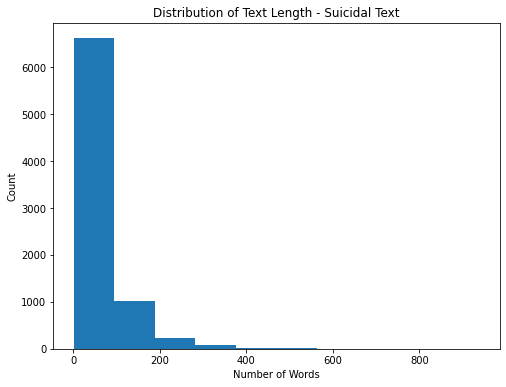

In [ ]:
# Plot average text length
ax = train_data_suicidal['length'].plot(kind='hist',title='Distribution of Text Length - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()


Polarity Score Distribution

In [ ]:
# Polarity score distribution
def get_polarity(text):
  return TextBlob(text).sentiment.polarity
train_data_suicidal['Polarity'] = train_data_suicidal['cleaned_text'].apply(get_polarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


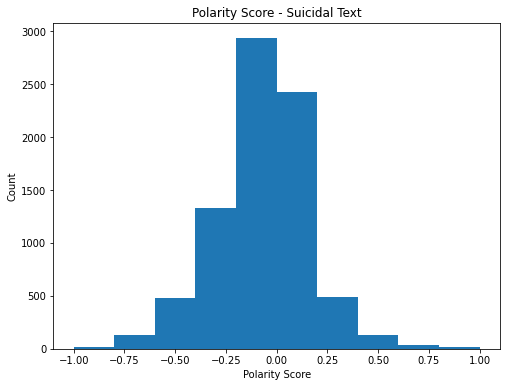

In [ ]:
# Plot polarity score graph
ax = train_data_suicidal['Polarity'].plot(kind='hist', title='Polarity Score - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

Bigram

In [ ]:
!pip install nltk==3.6.2
#import nltk
#import sklearn

print('The nltk version is {}.'.format(nltk.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.4 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


The nltk version is 3.7.


In [ ]:
#Remove more stop words and do bigram
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_data_suicidal['without_stopwords'] = train_data_suicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_suicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

bigram_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Bigram,Count
0,"(feel, like)",2971
1,"(want, die)",1235
2,"(want, live)",434
3,"(want, kill)",416
4,"(year, old)",407
5,"(suicidal, thought)",403
6,"(want, end)",366
7,"(mental, health)",344
8,"(get, bad)",331
9,"(year, ago)",327


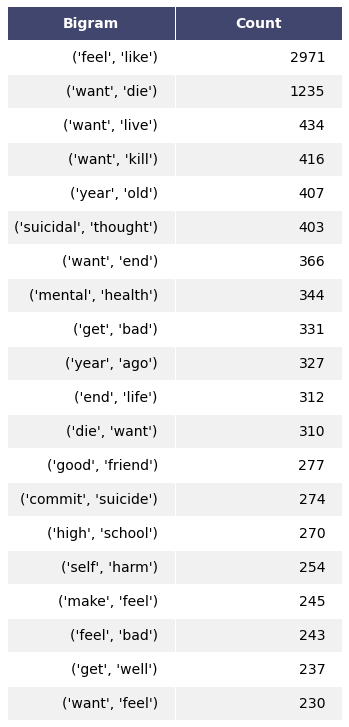

In [ ]:
#To make the table nicer
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(bigram_df, header_columns=0, col_width=3)

Non-suicidal Text

In [ ]:
tokenizer_depression = Tokenizer()
tokenizer_depression.fit_on_texts(train_data_depression["                                                                           text"])

In [ ]:
tokenizer_depression.word_counts.items()

odict_items([('i', 114736), ('know', 6312), ('what', 6178), ('it', 21791), ('is', 20696), ('that', 17769), ('causing', 94), ('my', 30179), ('depression', 3523), ('and', 44724), ('always', 2368), ('has', 2974), ('the', 30011), ('sense', 343), ('of', 21061), ('sheer', 18), ('loneliness', 191), ('a', 27892), ('feeling', 2251), ('am', 22850), ('all', 7075), ('too', 1964), ('familiar', 20), ('with', 10601), ('be', 8881), ('family', 1928), ('or', 6923), ('people', 4470), ('claiming', 11), ('to', 50778), ('friend', 1148), ('would', 4500), ('include', 21), ('romantic', 59), ('relationships', 304), ('but', 14812), ('at', 6035), ('age', 337), ('32', 25), ('only', 2744), ('having', 1340), ('had', 4280), ('2', 953), ('them', 3303), ('barely', 427), ('feels', 1229), ('necessary', 25), ('mention', 92), ('also', 1631), ('fact', 378), ('as', 4987), ('turns', 74), ('out', 5332), ('both', 392), ('those', 820), ('turned', 234), ('not', 26959), ('really', 4118), ('real', 571), ('hardly', 71), ('seems', 70

In [ ]:
word_freq_depression = pd.DataFrame(tokenizer_depression.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_depression.head()

,word,count
0,i,114736
29,to,50778
9,and,44724
7,my,30179
12,the,30011


# Word Frequency Bar Graph

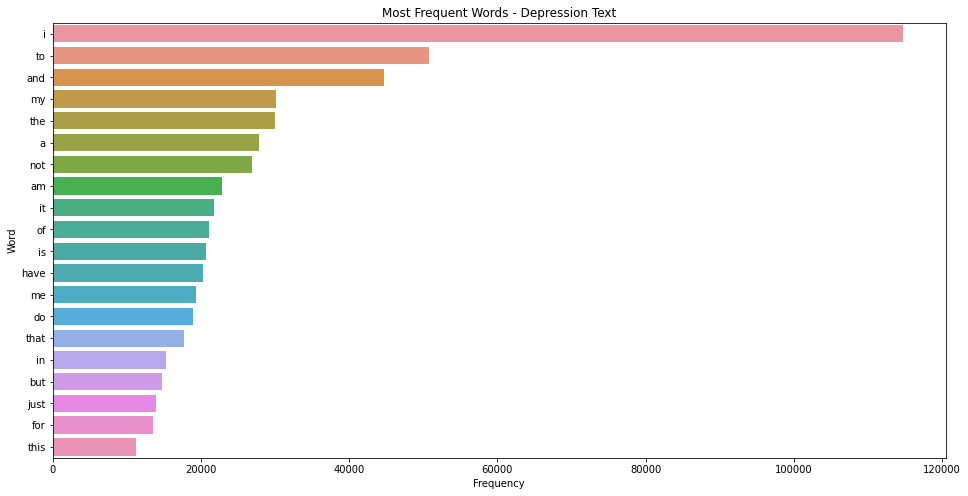

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_depression.iloc[:20])
plt.title('Most Frequent Words - Depression Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Wordcloud

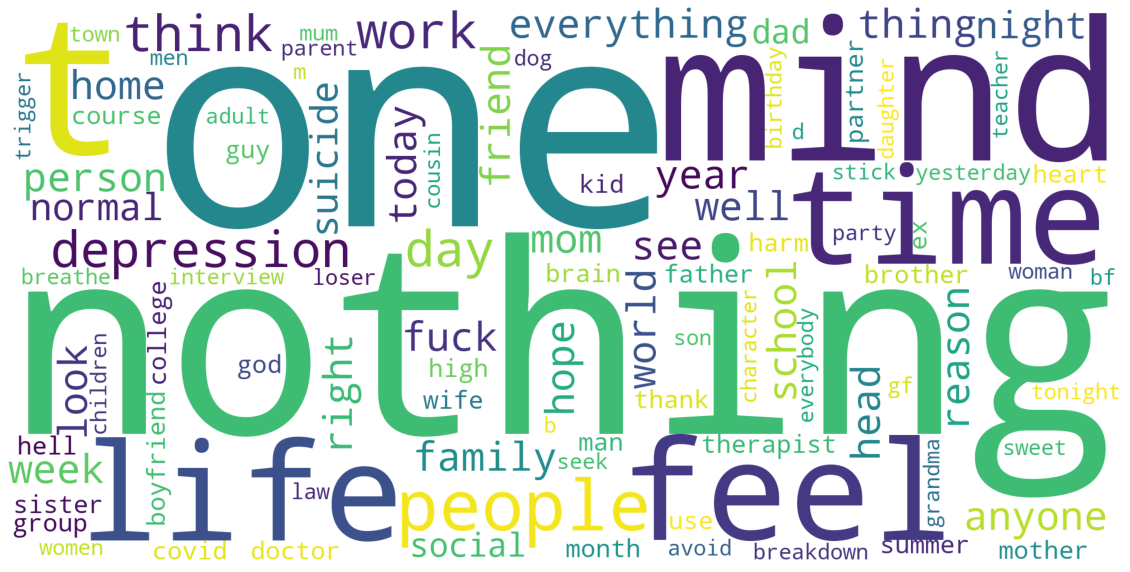

In [ ]:
# Wordcloud  
feature_names_depression = word_freq_depression['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_depression))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

**Distribution** of Text Length

In [ ]:
# Get average text length
train_data_depression['cleaned_text'] = train_data_depression['cleaned_text'].astype('str')
train_data_depression['length'] = train_data_depression['cleaned_text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


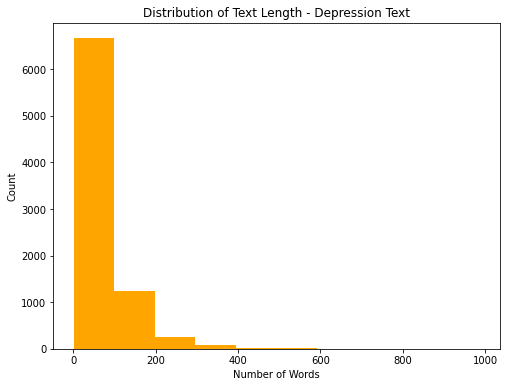

In [ ]:
# Plot distribution of text length
ax = train_data_depression['length'].plot(kind='hist',title='Distribution of Text Length - Depression Text', color='orange', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

# Polarity Score Distribution

In [ ]:
# Polarity score distribution
train_data_depression['cleaned_text'] = train_data_depression['cleaned_text'].astype('str')
train_data_depression['Polarity'] = train_data_depression['cleaned_text'].apply(get_polarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


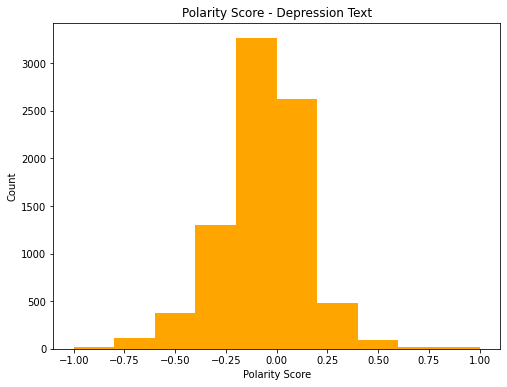

In [ ]:
# Plot polarity score graph
ax = train_data_depression['Polarity'].plot(kind='hist', title='Polarity Score - Depression Text', color="orange", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

# Bigram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


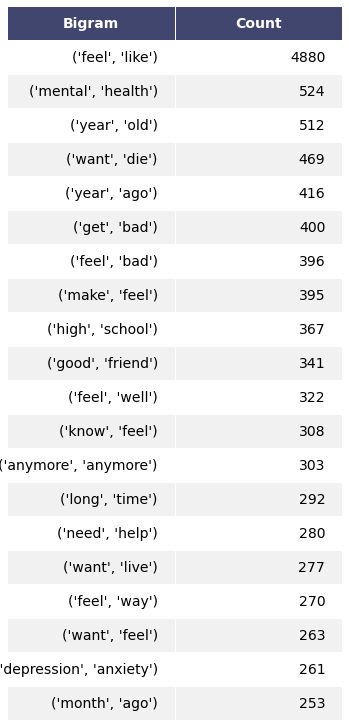

In [ ]:
#Remove more stop words and do bigram
stop_words = stopwords.words('english')
train_data_depression['without_stopwords'] = train_data_depression['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_depression['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

render_mpl_table(bigram_df, header_columns=0, col_width=3)

Normal Text

In [ ]:
tokenizer_normal = Tokenizer()
tokenizer_normal.fit_on_texts(train_data_normal["                                                                           text"])

In [ ]:
tokenizer_normal.word_counts.items()

odict_items([('i', 13630), ('feel', 5893), ('like', 1528), ('a', 3268), ('snob', 2), ('but', 1179), ('ve', 67), ('been', 440), ('bit', 276), ('skeptical', 20), ('of', 2578), ('it', 1652), ('from', 391), ('the', 4380), ('start', 84), ('because', 601), ('have', 1161), ('no', 240), ('idea', 34), ('who', 313), ('kenny', 2), ('werner', 1), ('is', 1105), ('and', 5016), ('neither', 5), ('does', 62), ('thomas', 1), ('musician', 1), ('gave', 17), ('me', 1203), ('book', 43), ('should', 172), ('run', 36), ('always', 194), ('controlled', 2), ('myself', 426), ('pretty', 204), ('well', 140), ('at', 716), ('dinner', 11), ('did', 178), ('not', 985), ('even', 295), ('guilty', 46), ('personally', 16), ('would', 343), ('gladly', 3), ('pay', 16), ('someone', 131), ('more', 601), ('just', 718), ('to', 4630), ('be', 932), ('treated', 10), ('with', 1069), ('dignity', 4), ('respect', 16), ('actually', 98), ('valued', 31), ('customer', 5), ('ended', 19), ('up', 513), ('feeling', 2631), ('terrific', 24), ('abou

In [ ]:
word_freq_normal = pd.DataFrame(tokenizer_normal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_normal.head()

,word,count
0,i,13630
1,feel,5893
23,and,5016
51,to,4630
13,the,4380


Word Frequency Bar Graph

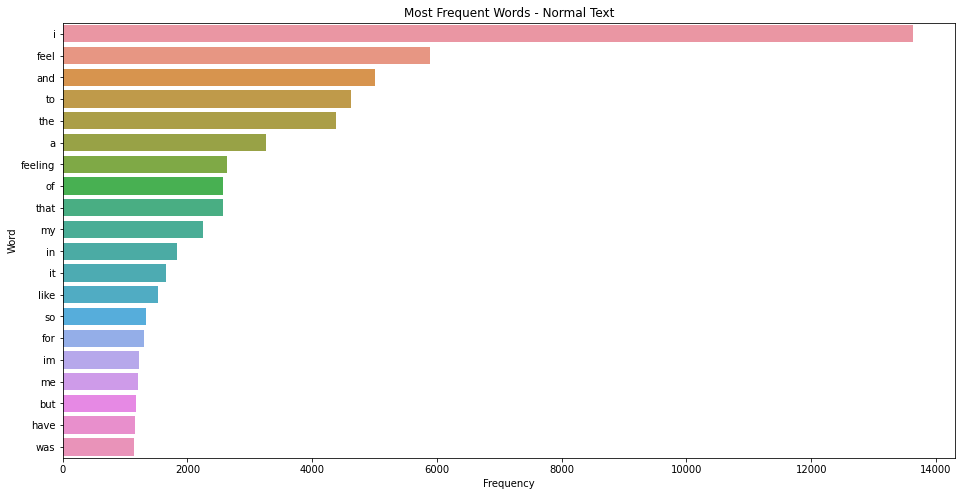

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_normal.iloc[:20])
plt.title('Most Frequent Words - Normal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

WordCloud

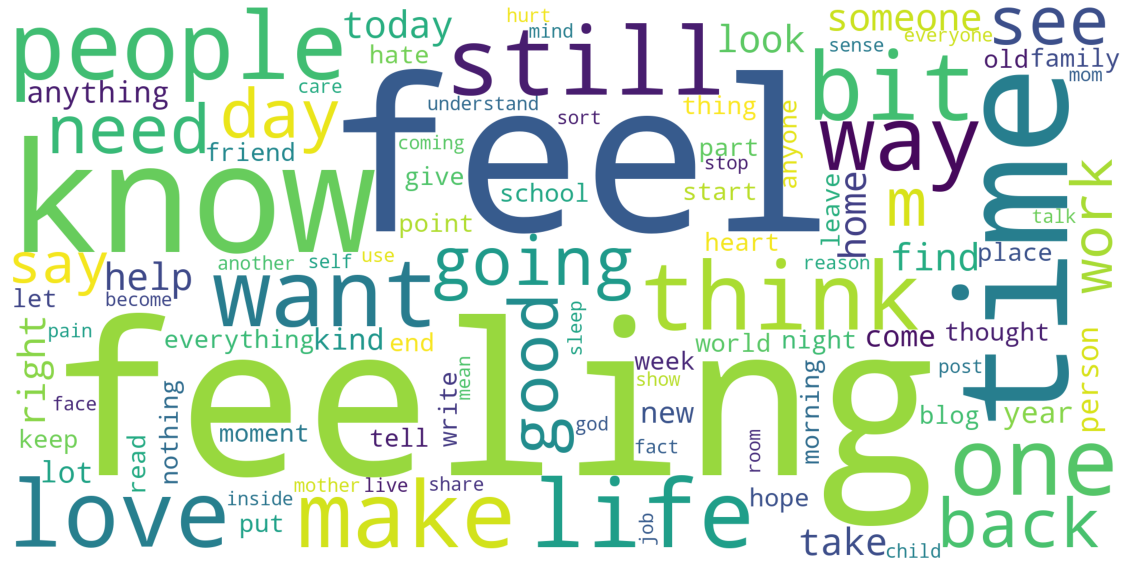

In [ ]:
# Wordcloud  
feature_names_normal = word_freq_normal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_normal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

Distribution of Text Length

In [ ]:
# Get average text length
train_data_normal['cleaned_text'] = train_data_normal['cleaned_text'].astype('str')
train_data_normal['length'] = train_data_normal['cleaned_text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


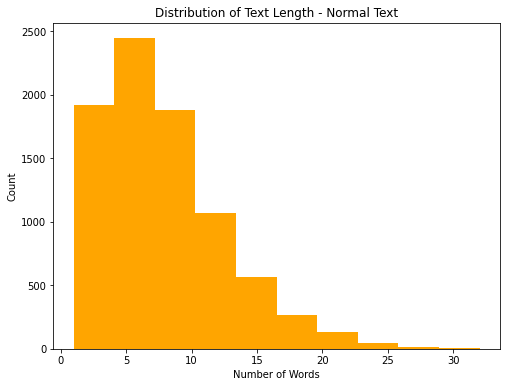

In [ ]:
# Plot distribution of text length
ax = train_data_normal['length'].plot(kind='hist',title='Distribution of Text Length - Normal Text', color='orange', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

Polarity Score Distribution

In [ ]:
# Polarity score distribution
train_data_normal['cleaned_text'] = train_data_normal['cleaned_text'].astype('str')
train_data_normal['Polarity'] = train_data_normal['cleaned_text'].apply(get_polarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


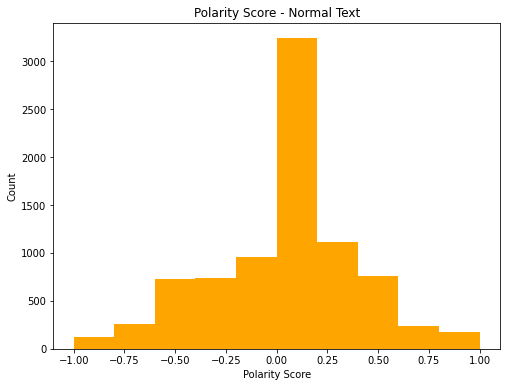

In [ ]:
# Plot polarity score graph
ax = train_data_normal['Polarity'].plot(kind='hist', title='Polarity Score - Normal Text', color="orange", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

Bigram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


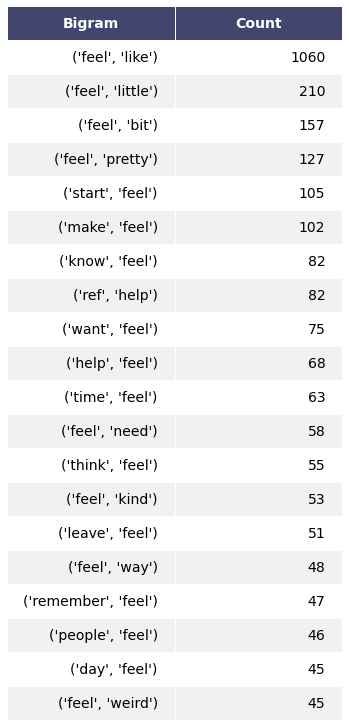

In [ ]:
#Remove more stop words and do bigram
stop_words = stopwords.words('english')
train_data_normal['without_stopwords'] = train_data_normal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_normal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

render_mpl_table(bigram_df, header_columns=0, col_width=3)